#Transit Fit Code - Part 1

Import Python libraries

In [1]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema
import emcee
import ipdb
import corner
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = 10,8  # Default image size for this interactive session
import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

Upload the Excel Files containing Transit Fit Parameters

In [2]:
physical = pd.read_excel('Physical.xlsx', sheetname='Sheet1')
targetParams = pd.read_excel('Results.xlsx', sheetname='TAP')

## Transit Fit Parameters

In [3]:
class Star:    
    def __init__(self, name, midts, per, per_err, mass, mass_err, radius,
                 radius_err, teff, teff_err, b, b_err, rprs, rp, lld, qld,
                 timeLC, fluxLC):
        
        self.name = name
        self.midts = midts
        self.ecc = 0.0
        self.per = per
        self.per_err = per_err
        
        self.mass = mass
        self.mass_err = mass_err
        self.radius = radius
        self.radius_err = radius_err
        self.teff = teff
        self.teff_err = teff_err
        
        self.b = b
        self.b_err = b_err
        self.rprs = rprs
        self.depth = rprs ** 2 # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
        self.ars = 0.0
        
        self.rp = rp #Earth radii
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. Rp needs to be in Earth radii
        
        self.lld = lld
        self.qld = qld
        self.diffld = lld - qld
        
        self.timeLC = timeLC
        self.fluxLC = fluxLC
        
        self.transits = np.empty(0)
        self.transRange = np.empty(0)
        self.flag = np.empty(0)
        self.f_trans = np.empty(0)
        self.t_trans = np.empty(0)
        self.dt = np.empty(0)
        self.error_foldedLC = np.empty(0)
        
        
        self.optimize1 = np.empty(0)
        
    def Print(self):
        print("Star {}".format(self.name))

Upload Excel Files containing the parameters of each system.

In [4]:
physical = pd.read_excel('Physical.xlsx', sheetname='Sheet1')
targetParams = pd.read_excel('Results.xlsx', sheetname='TAP')

Number of targets that this code will analyze

In [5]:
num = 12

In [6]:
tKep = 29.42/(60.0*24.0)
transit_range = np.array([0.4, 0.18, 0.07, 0.15, 0.12, 0.08, 0.08, 0.12, 0.15, 0.08, 0.02, 0.15])

targets = []
for i in range(num):
    name = "%.0f" % targetParams["EPIC"][i]
    midts = targetParams["midts"][i]
    per = targetParams["per"][i] #days
    
    per_lo = targetParams["per_lo"][i]
    per_hi = targetParams["per_hi"][i]
    per_err = np.mean([per_lo, per_hi])
    
    # Stellar mass
    mass = physical["mass"][i]
    mass_lo = physical["mass_lo"][i]
    mass_hi = physical["mass_hi"][i]
    mass_err = np.mean([mass_lo, mass_hi])
    
    # Stellar radius 
    radius = physical["radius"][i]
    radius_lo = physical["radius_lo"][i]
    radius_hi = physical["radius_hi"][i]
    radius_err = np.mean([radius_lo, radius_hi])
    
    #Effective temperature (In Kelvin)
    teff = physical["Teff"][i]
    teff_lo = physical["Teff_lo"][i]
    teff_hi = physical["Teff_hi"][i]
    teff_err = np.mean([teff_lo, teff_hi])
    
    # Impact parameter b
    b = targetParams["b"][i]
    b_lo = targetParams["b_lo"][i]
    b_hi = targetParams["b_hi"][i]
    b_err = np.mean([b_lo, b_hi])
        
    rprs = targetParams["rp/rs"][i] # Ratio Rp/Rs
    rprs_lo = targetParams["rp/rs_lo"][i]
    rprs_hi = targetParams["rp/rs_hi"][i]
    rprs_err = np.mean([rprs_lo, rprs_hi])
    
    rp = targetParams["rp"][i] # Planetary radius (Earth radii)
    
    lld = targetParams["LLD"][i] # Linear 
    qld = targetParams["QLD"][i] # Quadratic
    
    # Upload LC data
    data = pd.read_table(name+"transits.csv", sep=',', dtype = {'flux': np.float64}, header = None, names=['time', 'flux'])
    
    timeLC = data['time']
    fluxLC = data['flux']

    trange = transit_range[i]
 
    star = Star(name, midts, per, per_err, mass, mass_err, radius, 
               radius_err, teff, teff_err, b, b_err, rprs, rp, lld, qld,
               timeLC, fluxLC)
    
    star.transRange = trange
     
    targets.append(star)

For each system, store its physical parameters 

In [61]:
def processStar(star):
    
    goodP = intro(star)  
    mark_transits(star)
    
    fig1 = plt.figure()
    plt.title('Light Curve - Target ' + star.name, fontsize = 14) 
    plt.ylabel('Detrended Flux', fontsize = 14)
    plt.xlabel('Time  (JD)', fontsize = 14)
   
    plotLC(star.name, star.timeLC, star.fluxLC)
    plt.show()
    
    transit_window(star, goodP)
    print "Nº of transits (theory):", len(star.transits), " at ", star.transits
    
    out_trans = out_transit(star)
    oot_fit(star)
    print "Nº of transits (observed):", len(star.transits)
  
    print "Standard deviation of the folded LC:", star.error_foldedLC
    
    fig2 = plt.figure()
    plotLC(star.name, star.dt, star.f_trans) 
    plt.title('Folded Light Curve - Target ' + star.name, fontsize = 14)
    plt.ylabel('Normalized Flux', fontsize = 14)
    plt.xlabel('Time (JD)', fontsize = 14)
    plotLC(star.name, star.dt, star.f_trans) #Plot folded LC
    plt.show()
    
    fig3 = plt.figure()
    colTrans(star)

--------- Star  201516974 ---------


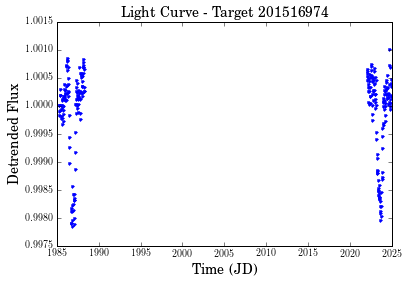

Nº of transits (theory): 2  at  [ 1986.80555162  2023.51544261]
Range of the transit (visual estimate): 0.4
Nº of transits (observed): 2
Standard deviation of the folded LC: 3.33066907388e-16


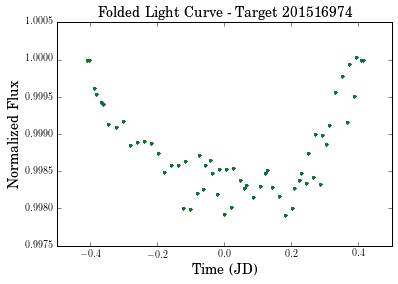

Color-coding of odd and even transits. They're shown in yellow and red, respectively.


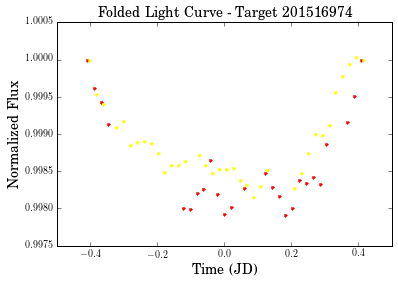

--------- Star  201920032 ---------


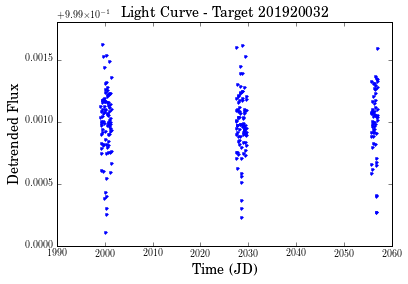

Nº of transits (theory): 3  at  [ 2000.205774    2028.47744553  2056.74911706]
Range of the transit (visual estimate): 0.18
Nº of transits (observed): 3
Standard deviation of the folded LC: 0.000190655519586


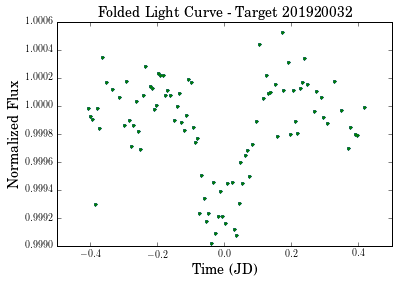

Color-coding of odd and even transits. They're shown in yellow and red, respectively.


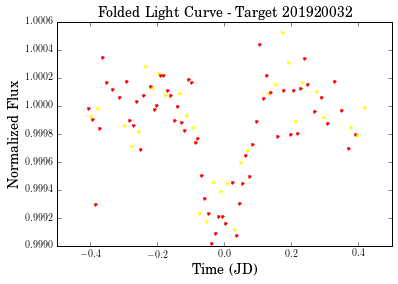

--------- Star  205924614 ---------


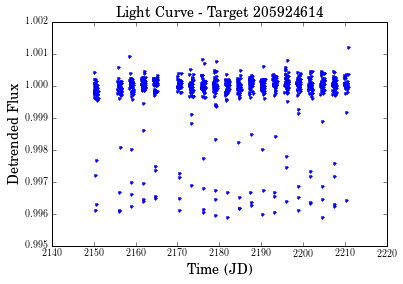

Nº of transits (theory): 21  at  [ 2150.424485    2153.27382604  2156.12316707  2158.97250811  2161.82184914
  2164.67119018  2167.52053121  2170.36987225  2173.21921328  2176.06855432
  2178.91789535  2181.76723639  2184.61657742  2187.46591846  2190.31525949
  2193.16460053  2196.01394156  2198.8632826   2201.71262363  2204.56196467
  2207.4113057 ]
Range of the transit (visual estimate): 0.07
Nº of transits (observed): 19
Standard deviation of the folded LC: 0.000203065806745


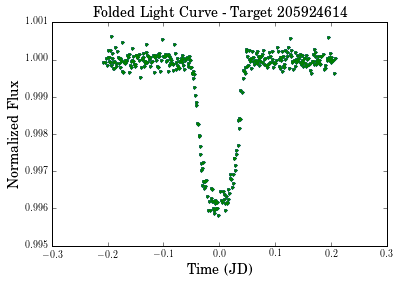

Color-coding of odd and even transits. They're shown in yellow and red, respectively.


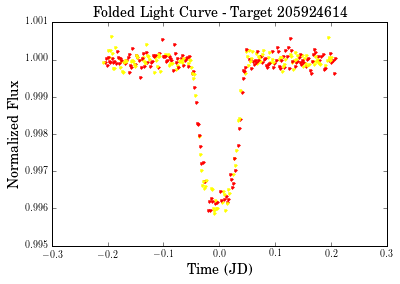

--------- Star  205985357 ---------


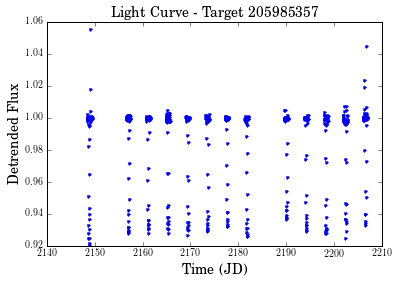

Nº of transits (theory): 15  at  [ 2148.728257    2152.85666526  2156.98507352  2161.11348177  2165.24189003
  2169.37029829  2173.49870655  2177.6271148   2181.75552306  2185.88393132
  2190.01233958  2194.14074784  2198.26915609  2202.39756435  2206.52597261]
Range of the transit (visual estimate): 0.15
Nº of transits (observed): 13
Standard deviation of the folded LC: 0.0149649092211


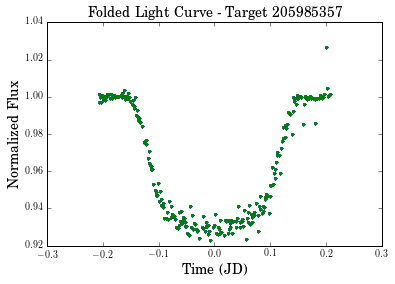

Color-coding of odd and even transits. They're shown in yellow and red, respectively.


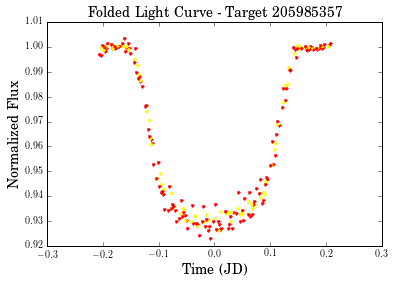

--------- Star  206029314 ---------


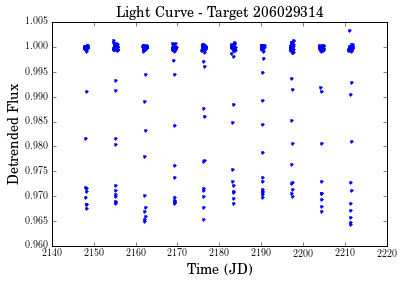

Nº of transits (theory): 10  at  [ 2148.06875     2155.09479332  2162.12083664  2169.14687996  2176.17292329
  2183.19896661  2190.22500993  2197.25105325  2204.27709657  2211.30313989]
Range of the transit (visual estimate): 0.12
Nº of transits (observed): 10
Standard deviation of the folded LC: 0.000375634443626


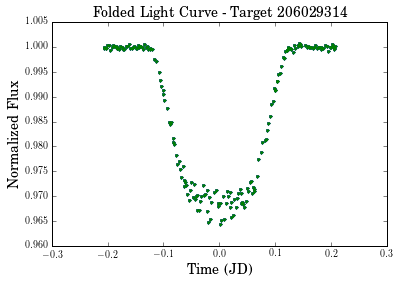

Color-coding of odd and even transits. They're shown in yellow and red, respectively.


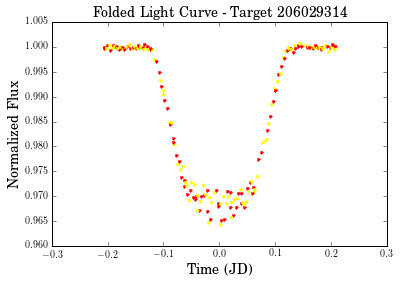

--------- Star  206038483 ---------


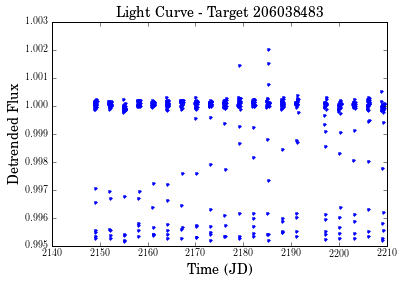

Nº of transits (theory): 21  at  [ 2149.05976     2152.06234098  2155.06492195  2158.06750293  2161.07008391
  2164.07266488  2167.07524586  2170.07782684  2173.08040781  2176.08298879
  2179.08556977  2182.08815074  2185.09073172  2188.09331269  2191.09589367
  2194.09847465  2197.10105562  2200.1036366   2203.10621758  2206.10879855
  2209.11137953]
Range of the transit (visual estimate): 0.08
Nº of transits (observed): 20
Standard deviation of the folded LC: 8.35929609277e-05


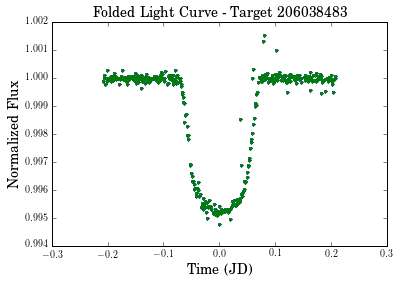

Color-coding of odd and even transits. They're shown in yellow and red, respectively.


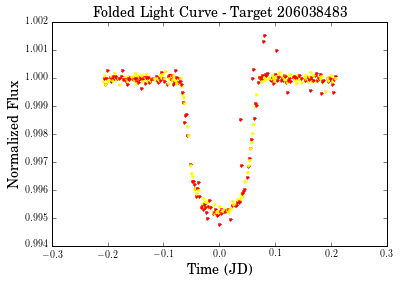

--------- Star  206061524 ---------


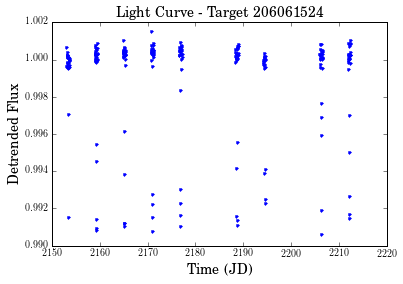

Nº of transits (theory): 11  at  [ 2153.323933    2159.20362989  2165.08332678  2170.96302367  2176.84272056
  2182.72241745  2188.60211433  2194.48181122  2200.36150811  2206.241205
  2212.12090189]
Range of the transit (visual estimate): 0.08
Nº of transits (observed): 9
Standard deviation of the folded LC: 0.00033051039199


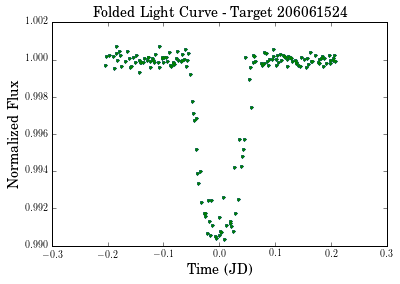

Color-coding of odd and even transits. They're shown in yellow and red, respectively.


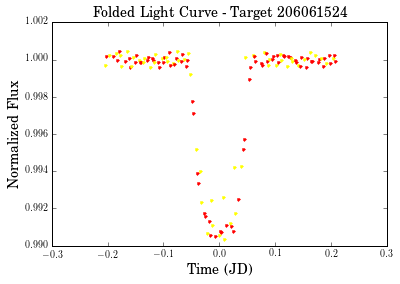

--------- Star  206082454 ---------


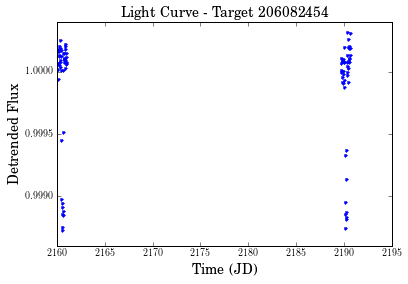

Nº of transits (theory): 2  at  [ 2160.54021572  2190.16619823]
Range of the transit (visual estimate): 0.12
Nº of transits (observed): 2
Standard deviation of the folded LC: 8.44467338983e-05


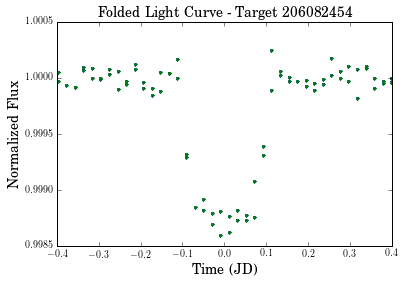

Color-coding of odd and even transits. They're shown in yellow and red, respectively.


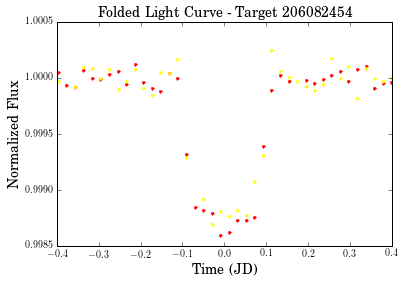

--------- Star  206155547 ---------


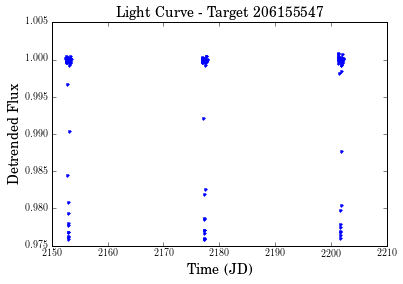

Nº of transits (theory): 3  at  [ 2152.884148    2177.27135138  2201.65855475]
Range of the transit (visual estimate): 0.15
Nº of transits (observed): 3
Standard deviation of the folded LC: 0.000364496221604


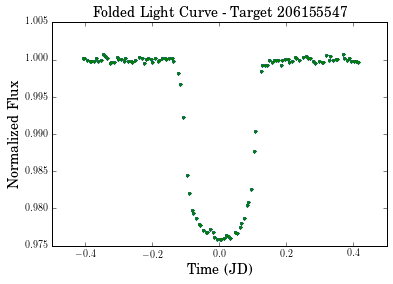

Color-coding of odd and even transits. They're shown in yellow and red, respectively.


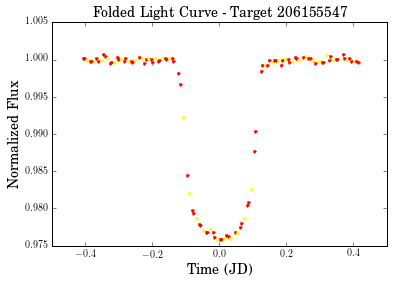

--------- Star  206245553 ---------


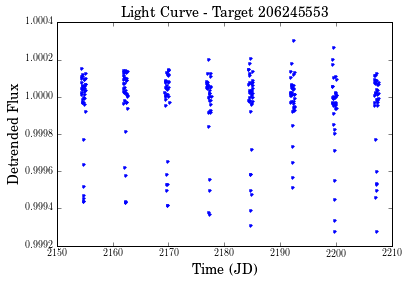

Nº of transits (theory): 8  at  [ 2154.672782    2162.16773498  2169.66268797  2177.15764095  2184.65259394
  2192.14754692  2199.64249991  2207.13745289]
Range of the transit (visual estimate): 0.08
Nº of transits (observed): 8
Standard deviation of the folded LC: 3.74269887044e-05


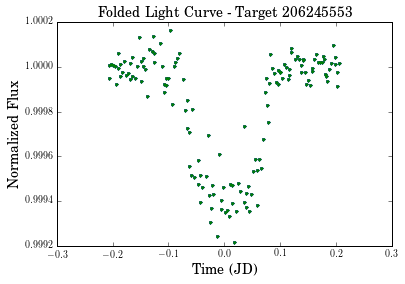

Color-coding of odd and even transits. They're shown in yellow and red, respectively.


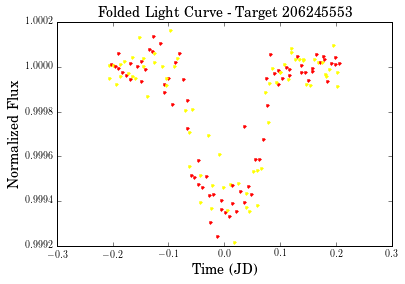

--------- Star  206247743 ---------


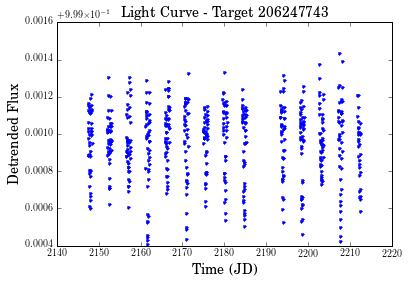

Nº of transits (theory): 15  at  [ 2147.821002    2152.42382923  2157.02665646  2161.6294837   2166.23231093
  2170.83513816  2175.43796539  2180.04079262  2184.64361985  2189.24644709
  2193.84927432  2198.45210155  2203.05492878  2207.65775601  2212.26058325]
Range of the transit (visual estimate): 0.02
Nº of transits (observed): 14
Standard deviation of the folded LC: 9.42958257538e-05


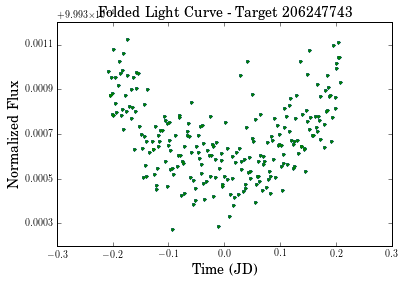

Color-coding of odd and even transits. They're shown in yellow and red, respectively.


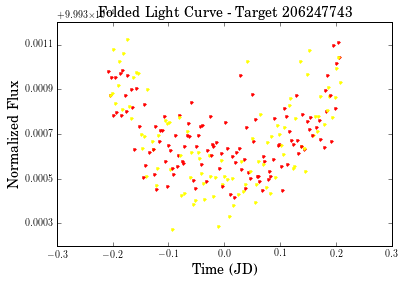

--------- Star  206311743 ---------


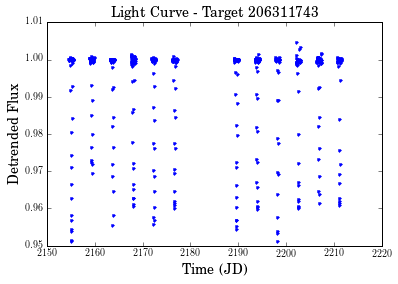

Nº of transits (theory): 14  at  [ 2155.041924    2159.35348755  2163.6650511   2167.97661465  2172.2881782
  2176.59974175  2180.9113053   2185.22286885  2189.5344324   2193.84599595
  2198.1575595   2202.46912305  2206.7806866   2211.09225015]
Range of the transit (visual estimate): 0.15
Nº of transits (observed): 12
Standard deviation of the folded LC: 0.000270380548418


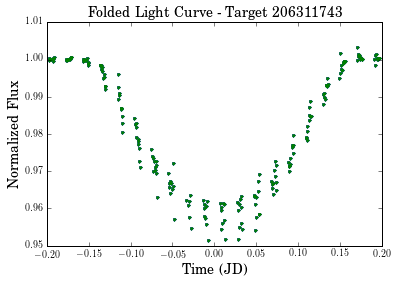

Color-coding of odd and even transits. They're shown in yellow and red, respectively.


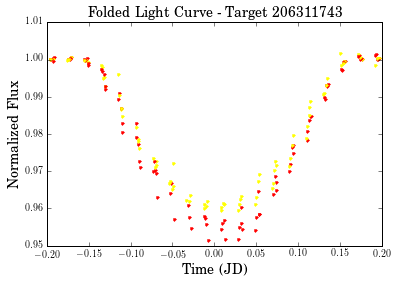

In [62]:
for star in targets:
    print "--------- Star ", star.name, "---------"
    processStar(star)

In [26]:
def intro(star):
    errorLC = np.std(star.fluxLC)
    meanFlux = np.mean(star.fluxLC)
    goodPoints = star.fluxLC <= meanFlux+3*errorLC
    return goodPoints

Identify transits in data

In [27]:
def mark_transits(star):
    
    minTime = min(star.timeLC)
    maxTime = max(star.timeLC)
       
    def my_range(start, end, step):
        while start <= end:
            yield start
            start += step
      
    minepoch = -20
    maxepoch = 20
    numepochs = maxepoch-minepoch+1
    
    transitLoc = np.empty(numepochs)

    for x in my_range(minepoch, maxepoch, 1):
        transit = star.midts+x*star.per
        transitLoc[x-minepoch]=transit

    goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
    transits = transitLoc[goodTrans] # Stores transit times
    
    star.transits = transits

In [28]:
def plotLC(name, time, flux):
    plt.plot(time,flux,'.')

In [29]:
def transit_window(star, goodP):
    t = star.timeLC[goodP]
    f = star.fluxLC[goodP]
    
    if len(star.transits) < 5.0:
        transit_window = 10.0 #In hours
    
    else:
        transit_window = 5.0
        
    window = transit_window/24 # In days
    sumPoints = 0
     
    for i in range(0,len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0,len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = t[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = f[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans
    
    star.flag = Flag
    star.f_trans = f_trans
    star.t_trans = t_trans 
    star.dt = dT

In [12]:
def out_transit(star):
    print "Range of the transit (visual estimate):", star.transRange
    dataBool = np.abs(star.dt) >= star.transRange # If true, point is outside of the transit.
    out = (star.t_trans <= star.transRange) & (star.t_trans >= star.transRange) # Boolean array. Tells which points are outside the transit.
    return out

For each individual transit: perform a linear fit to the out-of-transit regions.

In [13]:
def oot_fit(star): 
    
    corFlux = star.f_trans
    aux = np.empty (0)
    
    for i in range(0,len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        
        if len(star.dt[outsideBool] != 0): 
            z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
            p = np.poly1d(z)
            corFlux[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) # Divide transit by fit.
        
        else: 
            star.transits[i] = 0.0
    
    new_a = np.empty(0)
    
    for k in range(0,len(star.transits)):
        if star.transits[k] != 0.0:
            new_a = np.append(new_a, star.transits[k])
   
    star.transits = new_a

    err_folded = np.std(corFlux[outsideBool])
    
    star.error_foldedLC = err_folded
    star.f_trans = corFlux

Color-code odd/even transits

In [60]:
def colTrans(star):
    print "Color-coding of odd and even transits. They're shown in yellow and red, respectively."
    
    for i in range(0,len(star.transits)):
        transitBool = (star.flag == i)
        if i % 2 == 0: #even transit
            plt.plot(star.dt[transitBool],star.f_trans[transitBool], '.', color = 'red', label = 'Even')
        else:
            plt.plot(star.dt[transitBool],star.f_trans[transitBool], '.', color = 'yellow', label = 'Odd')
   
    plt.title('Folded Light Curve - Target ' + star.name, fontsize = 14)
    plt.ylabel('Normalized Flux', fontsize = 14)
    plt.xlabel('Time (JD)', fontsize = 14)
    plt.show()

# Theoretical Model

In [14]:
for star in targets:
    fixed = [star.per, star.ecc, star.mass, star.mass_err, star.radius, star.radius_err, star.diffld, tKep]
    print fixed
    print "Optimization for ", star.name
    opt(star, fixed)

[36.709890984200001, 0.0, 0.7, 0.29999999999999999, 1.5, 0.29999999999999999, 0.5585120616, 0.020430555555555556]
Optimization for  201516974


NameError: name 'opt' is not defined

Calculates the log of the likelihood of the transit model being the right model given the following parameters:

In [15]:
"""
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior)
    theta[7] = f0 = the out of eclipse flux
    
    
    Gaussian prior: We assume that the parameter we want to fit 
    is constrained within the range centered on the maximum value of a 
    Gaussian distribution. 
    
"""   

def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):

    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed 
    
    u1 = 0.5*(sumLD+diffLD) 
    u2 = sumLD-u1
 
    s = transit.System(transit.Central(mu1 = u1, mu2 = u2, mass = pmass, radius = pradius))
    
    body = transit.Body(r = np.sqrt(pdepth)*pradius, period = period, t0 = pt0, b = np.abs(pb), e = ecc)
    
    s.add_body(body)
    
    sigma2 = errorLC**2 + sigma**2
    
    ftheo = s.light_curve(timeLC, texp = tKep, tol=1e-08, maxdepth = 4)
    ftheo = ftheo - 1.0 + f0
    
    # Chi Squared
    return -0.5*(np.sum(((fluxLC-ftheo)**2)/sigma2 - np.log(1.0/sigma2)) +
                 ((pmass-mass)/masserr)**2 + 
                 ((pradius-radius)/radiuserr)**2)

def lnprior(theta): # This function ensures that estimates make physical sense.
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    
    if (0.4 < sumLD < 1.0) and (0 <= pb <0.9) and (0 <= sigma) and (pradius > 0) and (pdepth > 0):
        return 0.0 
    
    return -np.inf

def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [16]:
def opt(star, allfixed):
    nll = lambda *args: -lnprob(*args)
    
    # Minimization of the function "nll"
    result = op.minimize(nll, [1.2*star.depth, star.b, 0.0, 0.0, 0.6, star.mass, star.radius, 1.0], 
                         args = (star.dt, star.f_trans, star.error_foldedLC, allfixed),
                         options = {'disp': True}, 
                         method  ='Nelder-Mead')

    # Store best estimates in "result["x"]
    depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml  = result["x"]
    
    star.optimize1 = result["x"]

    # Readjust LD coefficients. 
    u1_ml = 0.5*(sumLD_ml + star.diffld)
    u2_ml = sumLD_ml-u1_ml
    
    # Compute each transit LC integrated over a Kepler long cadence exposure time 
    # with the result derived from optimization and plot theoretical model and observed data.
    
    s = transit.System(transit.Central(mu1 = u1_ml, mu2 = u2_ml, mass = mass_ml, radius = radius_ml))
    
    body = transit.Body(r = np.sqrt(depth_ml)*radius_ml, period = star.per, t0 = t0_ml, 
                        b = b_ml, e = star.ecc)
    
    s.add_body(body)
    t_theory = np.arange(-1.0, 1.0, tKep*0.01)
    f_theory = s.light_curve(t_theory, texp = tKep, tol = 1e-08, maxdepth = 4)
    f_theory = f_theory - 1.0 + f0_ml
    
    fig3 = plt.figure()
    plotLC(star.name, 24.0*star.dt, star.f_trans,'.') #Plot folded LC
    plotLC(star.name, 24.0*t_theory, f_theory, '.')
    plt.title('Folded Light Curve (Version 1)', fontsize=16)
    plt.xlabel('Time from midtransit [hours]', fontsize=14)
    plt.ylabel('Relative Flux', fontsize = 14)
    plt.show()
    
    results(star)

In [17]:
def results(star): #Print the best guesses & save them in a text file.
    print star.optimize1
    print star.error_foldedLC

    np.savetxt('1_'+star.name+'guesses.txt', (star.optimize1[0], star.optimize1[1], 
                                              star.optimize1[2], star.optimize1[3], 
                                              star.optimize1[4], star.optimize1[5], 
                                              star.optimize1[6], star.optimize1[7], 
                                              star.error_foldedLC), 
               fmt = '%.4e', delimiter='   ', header = """Best fit parameters. These are: 
               Depth, Impact parameter, time of transit, sigma (additional white noise),
               Sum of LD coefficients,  Mass of the star, Radius of the star (gaussian priors
               on both), the out of eclipse flux, and the standard deviation of the 
               out-of-transit flux.""") 